In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '../datasets/students_simple.csv'
df = pd.read_csv(DATA_PATH)

In [3]:
df.head()

,height,mass,income,iq,pages,age,bmi,work_exp,friends,test_time
0,159,45,430,95,24,20,3.533,26,5,8.5
1,160,61,640,115,32,25,2.623,63,7,6.2
2,161,56,610,111,24,28,2.875,94,10,6.8
3,162,48,330,97,24,19,3.375,16,4,12.0
4,162,54,420,105,60,23,3.000,49,2,7.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   height     20 non-null     int64  
 1   mass       20 non-null     int64  
 2   income     20 non-null     int64  
 3   iq         20 non-null     int64  
 4   pages      20 non-null     int64  
 5   age        20 non-null     int64  
 6   bmi        20 non-null     float64
 7   work_exp   20 non-null     int64  
 8   friends    20 non-null     int64  
 9   test_time  20 non-null     float64
dtypes: float64(2), int64(8)
memory usage: 1.7 KB


>Номера столбцов: 1, 6

In [5]:
print(df.columns[1], df.columns[6])

mass bmi


In [6]:
x, y = df.iloc[:, 1].values, df.iloc[:, 6].values

**1. Расчет корреляций**
1. Фехнера
2. Пирсона + доверительный интервал
3. Спирмена
4. Кенделла

In [7]:
n = len(x)
n

20

In [8]:
mx, my = np.mean(x), np.mean(y)
sign_x, sign_y = np.sign(x - mx), np.sign(y - my)
fechner = np.mean(sign_x * sign_y)
fechner

np.float64(-0.9)

>Получили обратную зависимость: при увеличении массы BMI уменьшается 💀

In [9]:
eps = 1e-10
std_x, std_y = np.sqrt(np.mean((x - mx) ** 2)), np.sqrt(np.mean((y - my) ** 2))
cov_xy = np.mean((x - mx) * (y - my))
pearson_r = cov_xy / (std_x * std_y + eps)
pearson_r

np.float64(-0.9606094762539479)

In [10]:
from scipy.stats import norm
alpha = 0.05

z = np.arctanh(pearson_r)
se_z = 1 / np.sqrt(n - 3)
z_crit = norm.ppf(1 - alpha/2)
z_lower, z_upper = z - z_crit * se_z, z + z_crit * se_z
lower, upper = np.tanh(z_lower), np.tanh(z_upper)
print(f'({lower}, {upper})')

(-0.9845908653787432, -0.9011643297202268)


>Получили обратную зависимость: при увеличении массы BMI уменьшается 💀💀

In [11]:
rank_x = pd.Series(x).rank()
rank_y = pd.Series(y).rank()
d = rank_x - rank_y
spearman = 1 - 6 * np.sum(d ** 2) / (n ** 3 - n)
spearman

np.float64(-0.9827067669172933)

>Получили обратную зависимость: при увеличении массы BMI уменьшается 💀💀💀

In [12]:
indices = np.argsort(x)
x_sorted = x[indices]
y_sorted = y[indices]

T = 0
for i in range(n - 1):
    for j in range(i + 1, n):
        T += np.sign(x_sorted[j] - x_sorted[i]) * np.sign(y_sorted[j] - y_sorted[i]) 

kendall = 2 * T / (n * (n - 1))
kendall

np.float64(-0.9315789473684211)

>Получили обратную зависимость: при увеличении массы BMI уменьшается 💀💀💀💀

**2. Визуализация**
1. Гистограммы
2. График рассеяния (scatter plot)

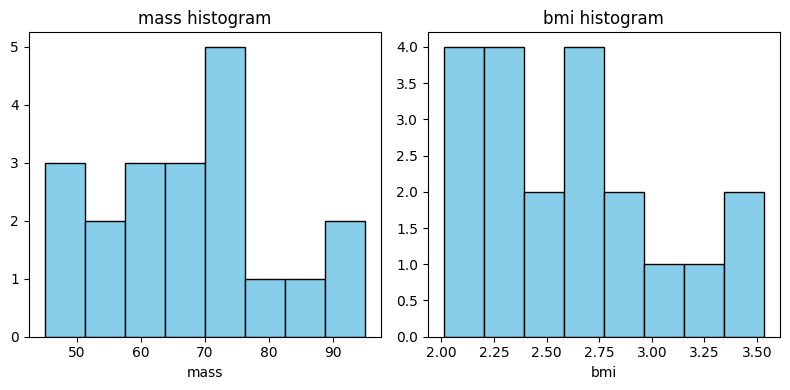

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].hist(x, bins=8, color='skyblue', edgecolor='black')
axs[0].set_title(f'{df.columns[1]} histogram')
axs[0].set_xlabel(df.columns[1])

axs[1].hist(y, bins=8, color='skyblue', edgecolor='black')
axs[1].set_title(f'{df.columns[6]} histogram')
axs[1].set_xlabel(df.columns[6])

plt.tight_layout()
plt.show()

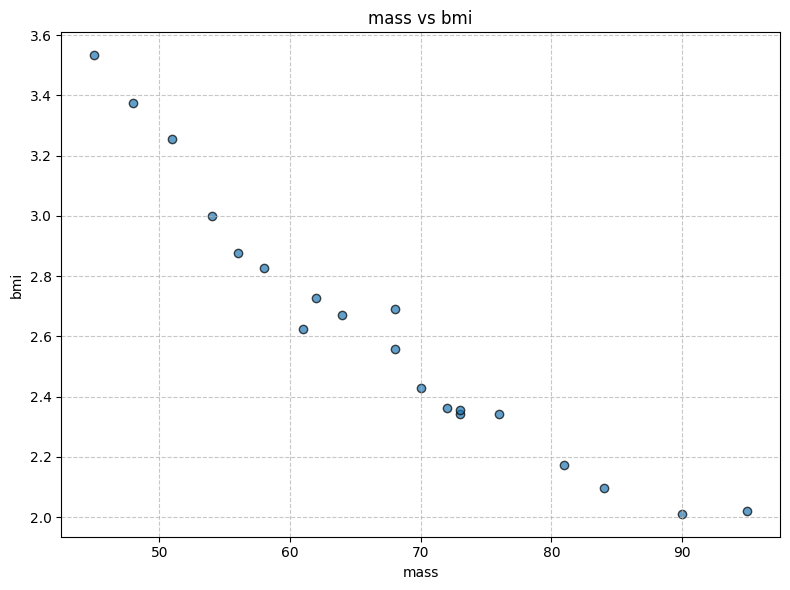

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.7, edgecolor='black')
plt.title(f'{df.columns[1]} vs {df.columns[6]}')
plt.xlabel(df.columns[1])
plt.ylabel(df.columns[6])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

>Точки на графике рассеяния ложатся по нисходящей, что закономерно для полученных ранее резульатов

**3. Уравнение регрессии**

Построить уравнение регрессии по видам:
1. линейная, $y=w_1 x + w_0$
2. квадратичная, $y = w_2 x^2 + w_1 x + w_0$
3. гиперболическая, $y = \frac{w_1}{x} + w_0$ 
4. показательная, $y = w_1^x \cdot w_0$

In [15]:
def least_squares_method(X, y):
    XTX_inv = np.linalg.pinv(X.T @ X)
    XTy = X.T @ y
    w = XTX_inv @ XTy
    return w

In [16]:
X_lin = np.column_stack([np.ones(n), x])
w_lin = least_squares_method(X_lin, y)
print(f'linear regression: y = {w_lin[1]:.4f}x + {w_lin[0]:.4f}')

linear regression: y = -0.0308x + 4.6881


In [17]:
X_quad = np.column_stack([np.ones(n), x, x**2])
w_quad = least_squares_method(X_quad, y)
print(f'quadratic regression: y = {w_quad[2]:.4f}x^2 + {w_quad[1]:.4f}x + {w_quad[0]:.4f}')

quadratic regression: y = 0.0005x^2 + -0.0990x + 6.9596


In [18]:
X_hyper = np.column_stack([np.ones(n), 1/x])
w_hyper = least_squares_method(X_hyper, y)
print(f'hyperbolic regression: y = {w_hyper[1]:.4f}/x + {w_hyper[0]:.4f}')

hyperbolic regression: y = 135.2427/x + 0.5275


In [19]:
X_exp = np.column_stack([np.ones(n), x])
w_exp = least_squares_method(X_exp, np.log(y))
print(f'exponential regression: y = {np.exp(w_exp[1]):.4f}^x * {np.exp(w_exp[0]):.4f}')

exponential regression: y = 0.9884^x * 5.6857


In [20]:
y_lin = lambda x: w_lin[1] * x + w_lin[0]
y_quad = lambda x: w_quad[2] * x**2 + w_quad[1] * x + w_quad[0]
y_hyper = lambda x: w_hyper[1] / x + w_hyper[0]
y_exp = lambda x: np.exp(w_exp[1])**x * np.exp(w_exp[0])

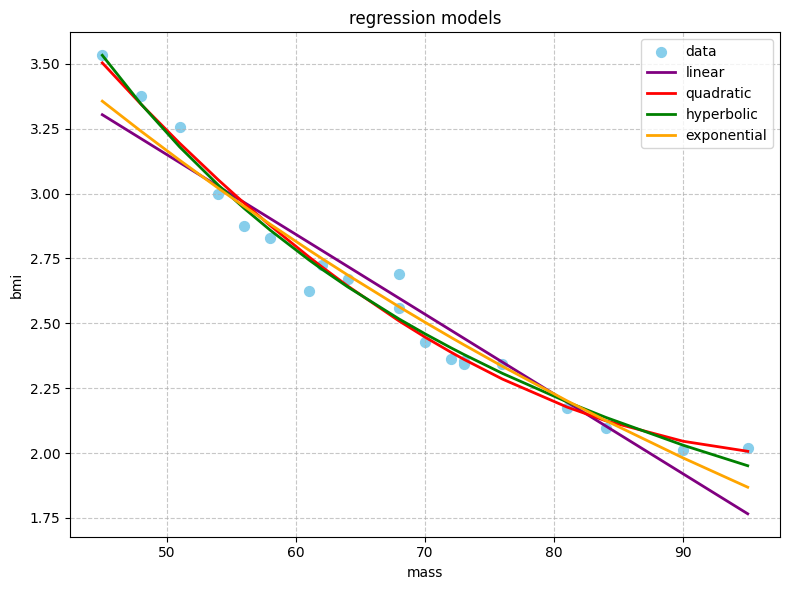

In [21]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='skyblue', s=50, label='data')
plt.plot(x_sorted, y_lin(x_sorted), color='purple', linewidth=2, label='linear')
plt.plot(x_sorted, y_quad(x_sorted), color='red', linewidth=2, label='quadratic')
plt.plot(x_sorted, y_hyper(x_sorted), color='green', linewidth=2, label='hyperbolic')
plt.plot(x_sorted, y_exp(x_sorted), color='orange', linewidth=2, label='exponential')
plt.title(f'regression models')
plt.xlabel(df.columns[1])
plt.ylabel(df.columns[6])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

mse_quad = mean_squared_error(y, y_quad(x))
r2_quad = r2_score(y, y_quad(x))

mse_hyper = mean_squared_error(y, y_hyper(x))
r2_hyper = r2_score(y, y_hyper(x))

print(f'quadratic regression: mse = {mse_quad:.4f}, r2 = {r2_quad:.4f}')
print(f'hyperbolic regression: mse = {mse_hyper:.4f}, r2 = {r2_hyper:.4f}')

quadratic regression: mse = 0.0040, r2 = 0.9779
hyperbolic regression: mse = 0.0038, r2 = 0.9791


>Наилучшей моделью будем считать гиперболическую регрессию, наихудшей – линейную

In [23]:
from scipy.stats import f

def fisher_test(y, y_pred, k, alpha=0.05):
    n = len(y)
    r2 = r2_score(y, y_pred)
    F = (r2 / k) / ((1 - r2) / (n - k - 1))
    f_crit = f.ppf(1 - alpha, k, n - k - 1)   
    return F, f_crit

In [24]:
F_best, f_crit_best = fisher_test(y, y_hyper(x), 1)
print(f'for hyperbolic regression:')
print(f'F-statistic: {F_best:.4f}')
print(f'сritical F (alpha=0.05): {f_crit_best:.4f}')

for hyperbolic regression:
F-statistic: 844.5955
сritical F (alpha=0.05): 4.4139


In [25]:
F_worst, f_crit_worst = fisher_test(y, y_lin(x), 1)
print(f'for linear regression:')
print(f'F-statistic: {F_worst:.4f}')
print(f'сritical F (alpha=0.05): {f_crit_worst:.4f}')

for linear regression:
F-statistic: 215.0718
сritical F (alpha=0.05): 4.4139


>Обе модели статистически значимы, но гиперболическая регрессия значительно лучше линейной